In [2]:
import numpy as np
import os 
import json
import requests
import matplotlib.pyplot as plt 

In [56]:
artworks = []
tags = {}
image_loc = './artworks/images'
predef_keys = ['style', 'genre', 'yearAsString']

for filename in os.listdir('./artworks'):
    if filename.endswith('.json'):
        artist = json.load(open(os.path.join('./artworks', filename), 'r'))
        for artwork in artist:
            for key in predef_keys:
                if (key in artwork) and (artwork[key] != ""):
                    if artwork[key] not in tags:
                        tags[artwork[key]] = len(tags) # id that shit
#             if 'image' in artwork:
#                 url = artwork['image'].replace('!Large.jpg', '')
#                 print(f"Downlading {url}...")
#                 try:
#                     r = requests.get(url)
#                     savename = artwork['title'] + "_" + artwork['artistName'] +'.jpg'
#                     with open(os.path.join(image_loc, savename.strip()), 'wb') as f:
#                         f.write(r.content)
#                 except:
#                     print('\tFailed! Invalid schema')
#                     pass 

In [35]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import cv2
import random 
def visualize_scatter_with_images(X_2d_data, images, figsize=(45,45), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    ax.axis("off")
    plt.show()


In [41]:
images = []
org_images= []
files = os.listdir('./artworks/images')
chosen = random.sample(files, 500)
for filename in chosen:
    if filename.endswith('.jpg'):
        img = cv2.imread(os.path.join('./artworks/images', 
                                      filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (45, 45))
        org_images.append(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img.flatten()
        images.append(img)
images = np.array(images)

In [42]:
images_scaled = StandardScaler().fit_transform(images)

/home/lemurpwned/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/lemurpwned/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [43]:
pca = PCA(n_components=200)
pca_res = pca.fit_transform(images_scaled)

In [54]:
tsne = TSNE(n_components=2, perplexity=35.0, n_iter=3000)
tsne_result = tsne.fit_transform(pca_res)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

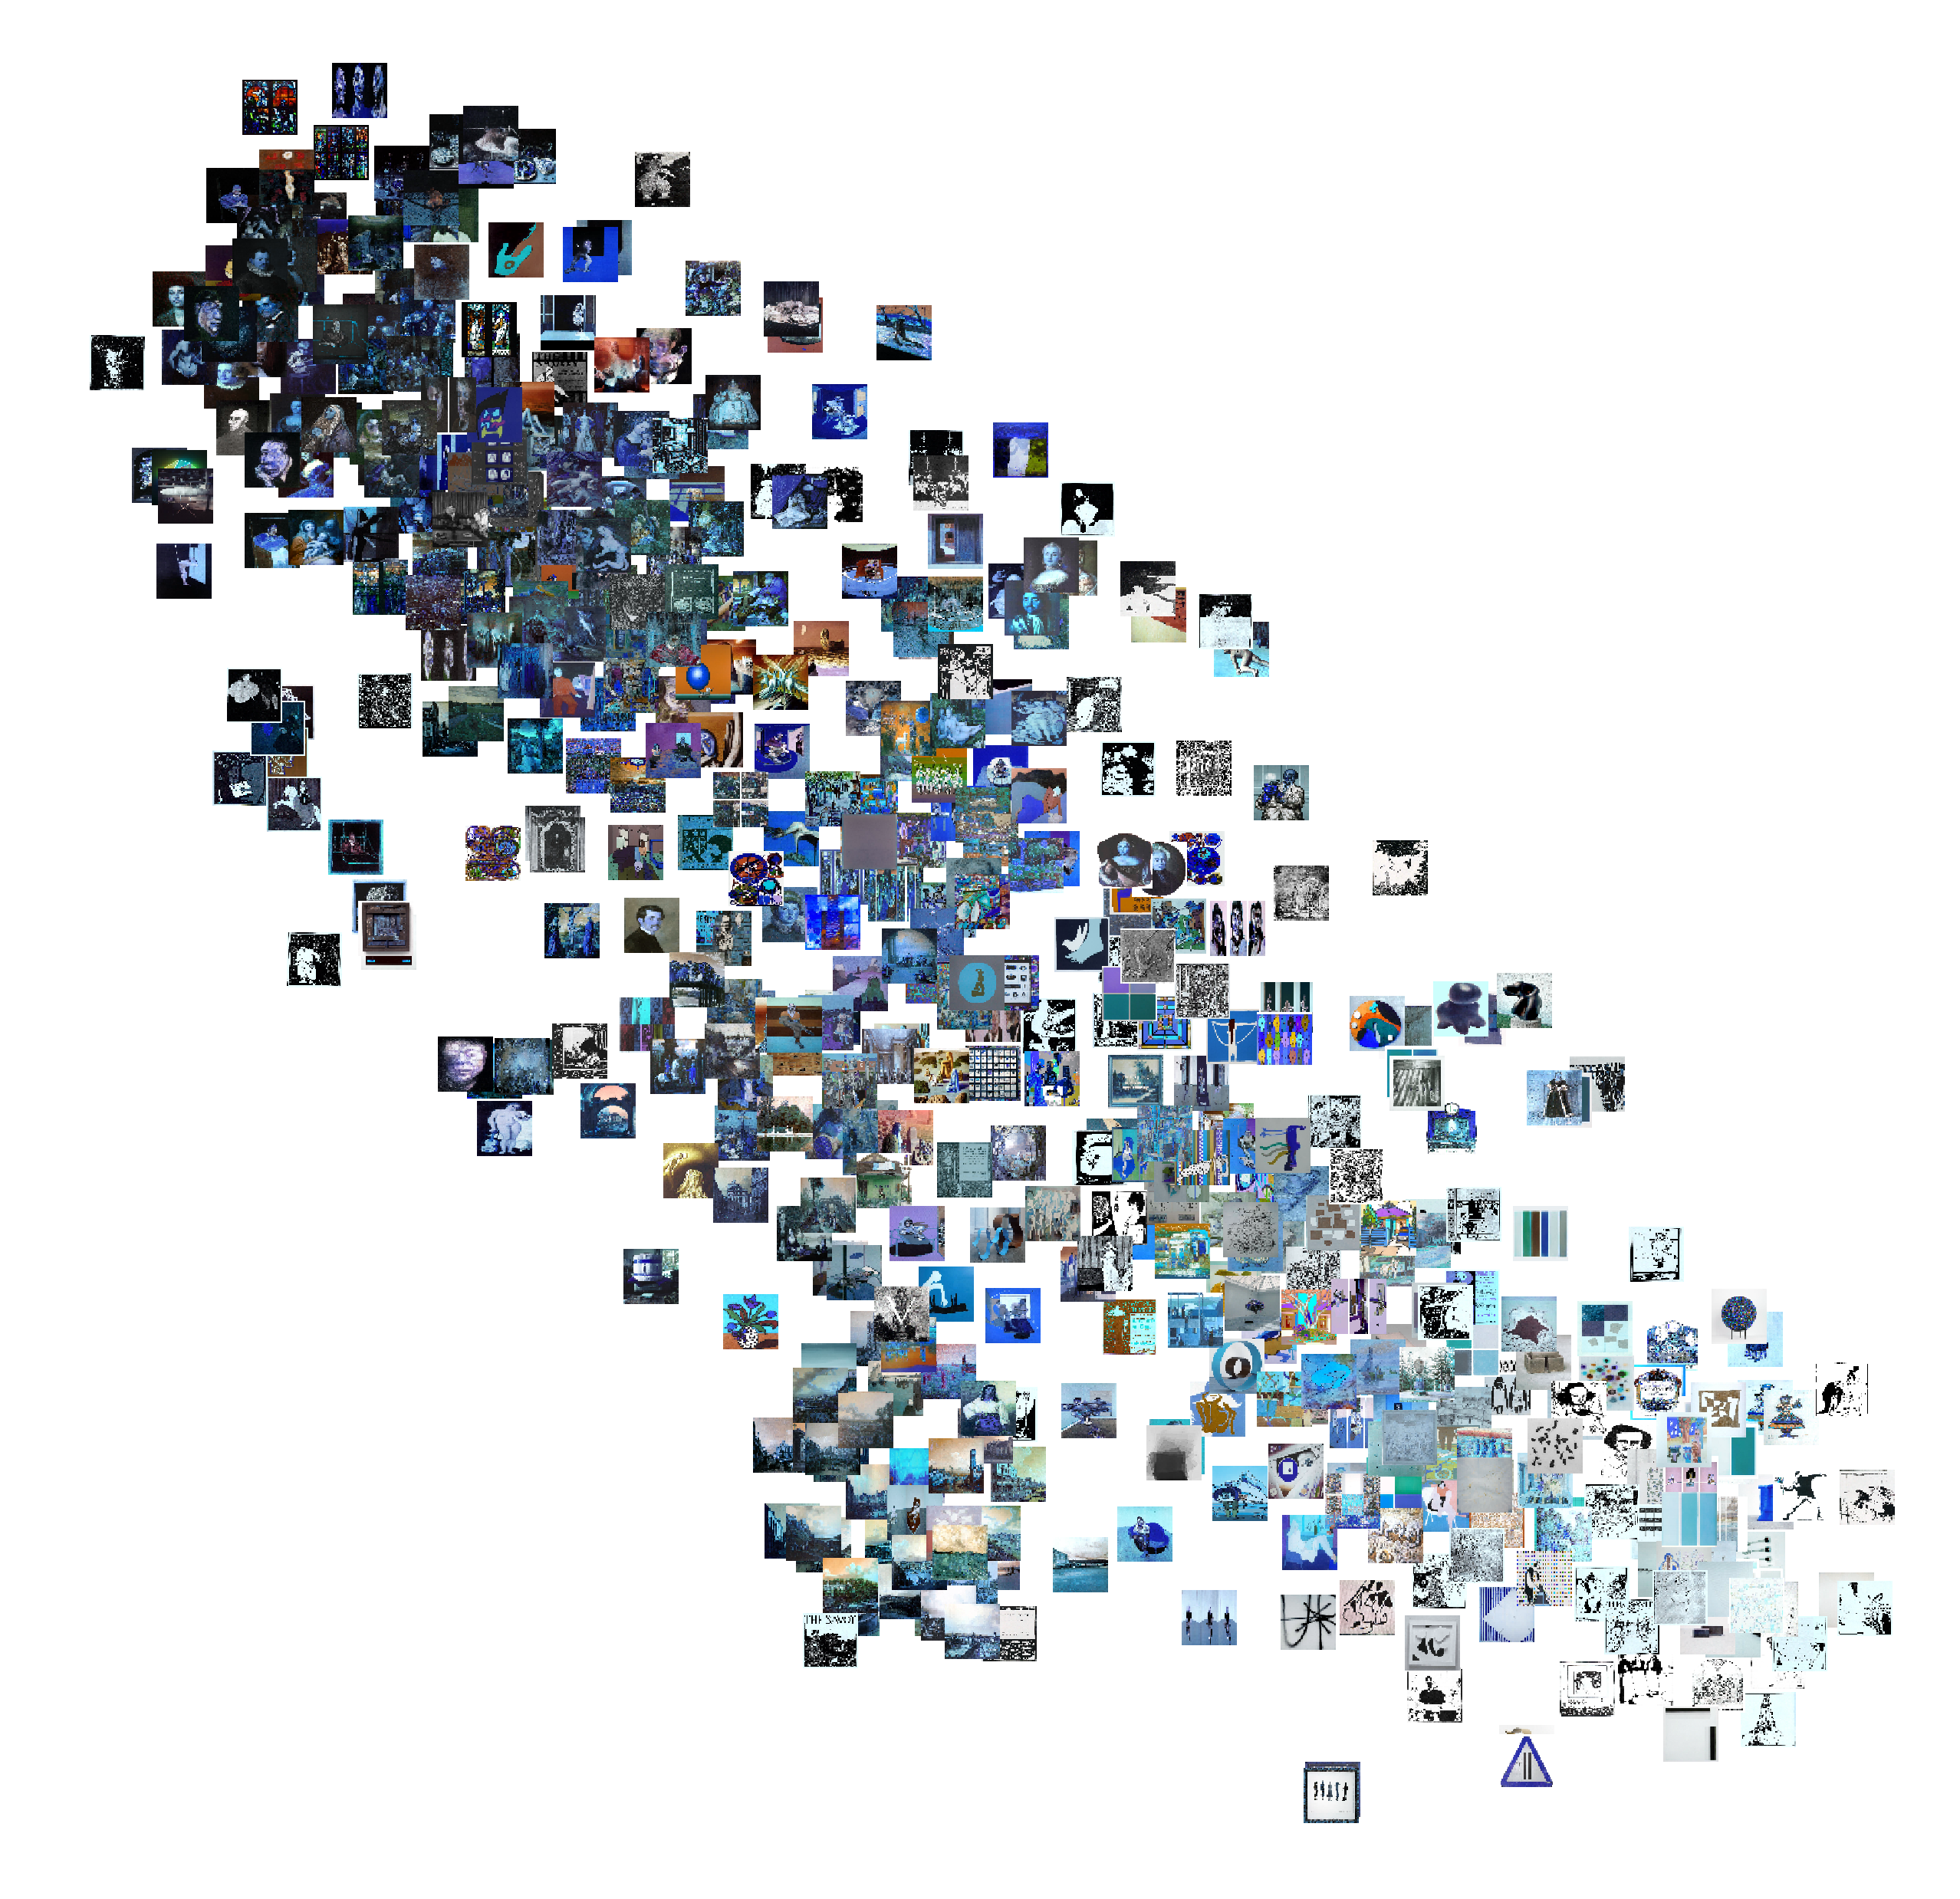

In [55]:
visualize_scatter_with_images(tsne_result_scaled, 
                                  org_images, 
                                  figsize=(45,45), 
                                  image_zoom=1.6)


In [150]:
img_vecs = []
pics = []
labels = []
hrefs = []
authors = []
titles = []
for filename in os.listdir('./artworks'):
    if filename.endswith('.json'):
        artist = json.load(open(os.path.join('./artworks', filename), 'r'))
        for artwork in artist:
            label = []
            if 'image' in artwork: # we have an image of that 
                try:
                    for key in predef_keys:
                        if artwork[key] == "":
                            raise ValueError("Dodge")
                        label.append(artwork[key])
                except:
                    continue
                image_vector = np.zeros(shape=(len(tags),))
                for key in predef_keys:
                    image_vector[tags[artwork[key]]] = 1
                url = artwork['image'].replace('!Large.jpg', '')
                savename = artwork['title'] + "_" + artwork['artistName'] +'.jpg'
                savename = os.path.join('./artworks/images', savename.strip()) # that's saved image
                try:
                    img = cv2.imread(savename, cv2.IMREAD_COLOR)
                    img = cv2.resize(img, (45, 45))
                except:
                    continue
                pics.append(img)
                img_vecs.append(image_vector)
                labels.append(label)
                hrefs.append(savename)
                authors.append(artwork['artistName'])
                titles.append(artwork['title'])
img_vecs = np.array(img_vecs)

In [151]:
print(img_vecs.shape, len(pics))
assert img_vecs.shape[0] == len(pics)

(1554, 589) 1554


In [152]:
tsne = TSNE(n_components=2, perplexity=35.0)
tsne_result = tsne.fit_transform(img_vecs)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

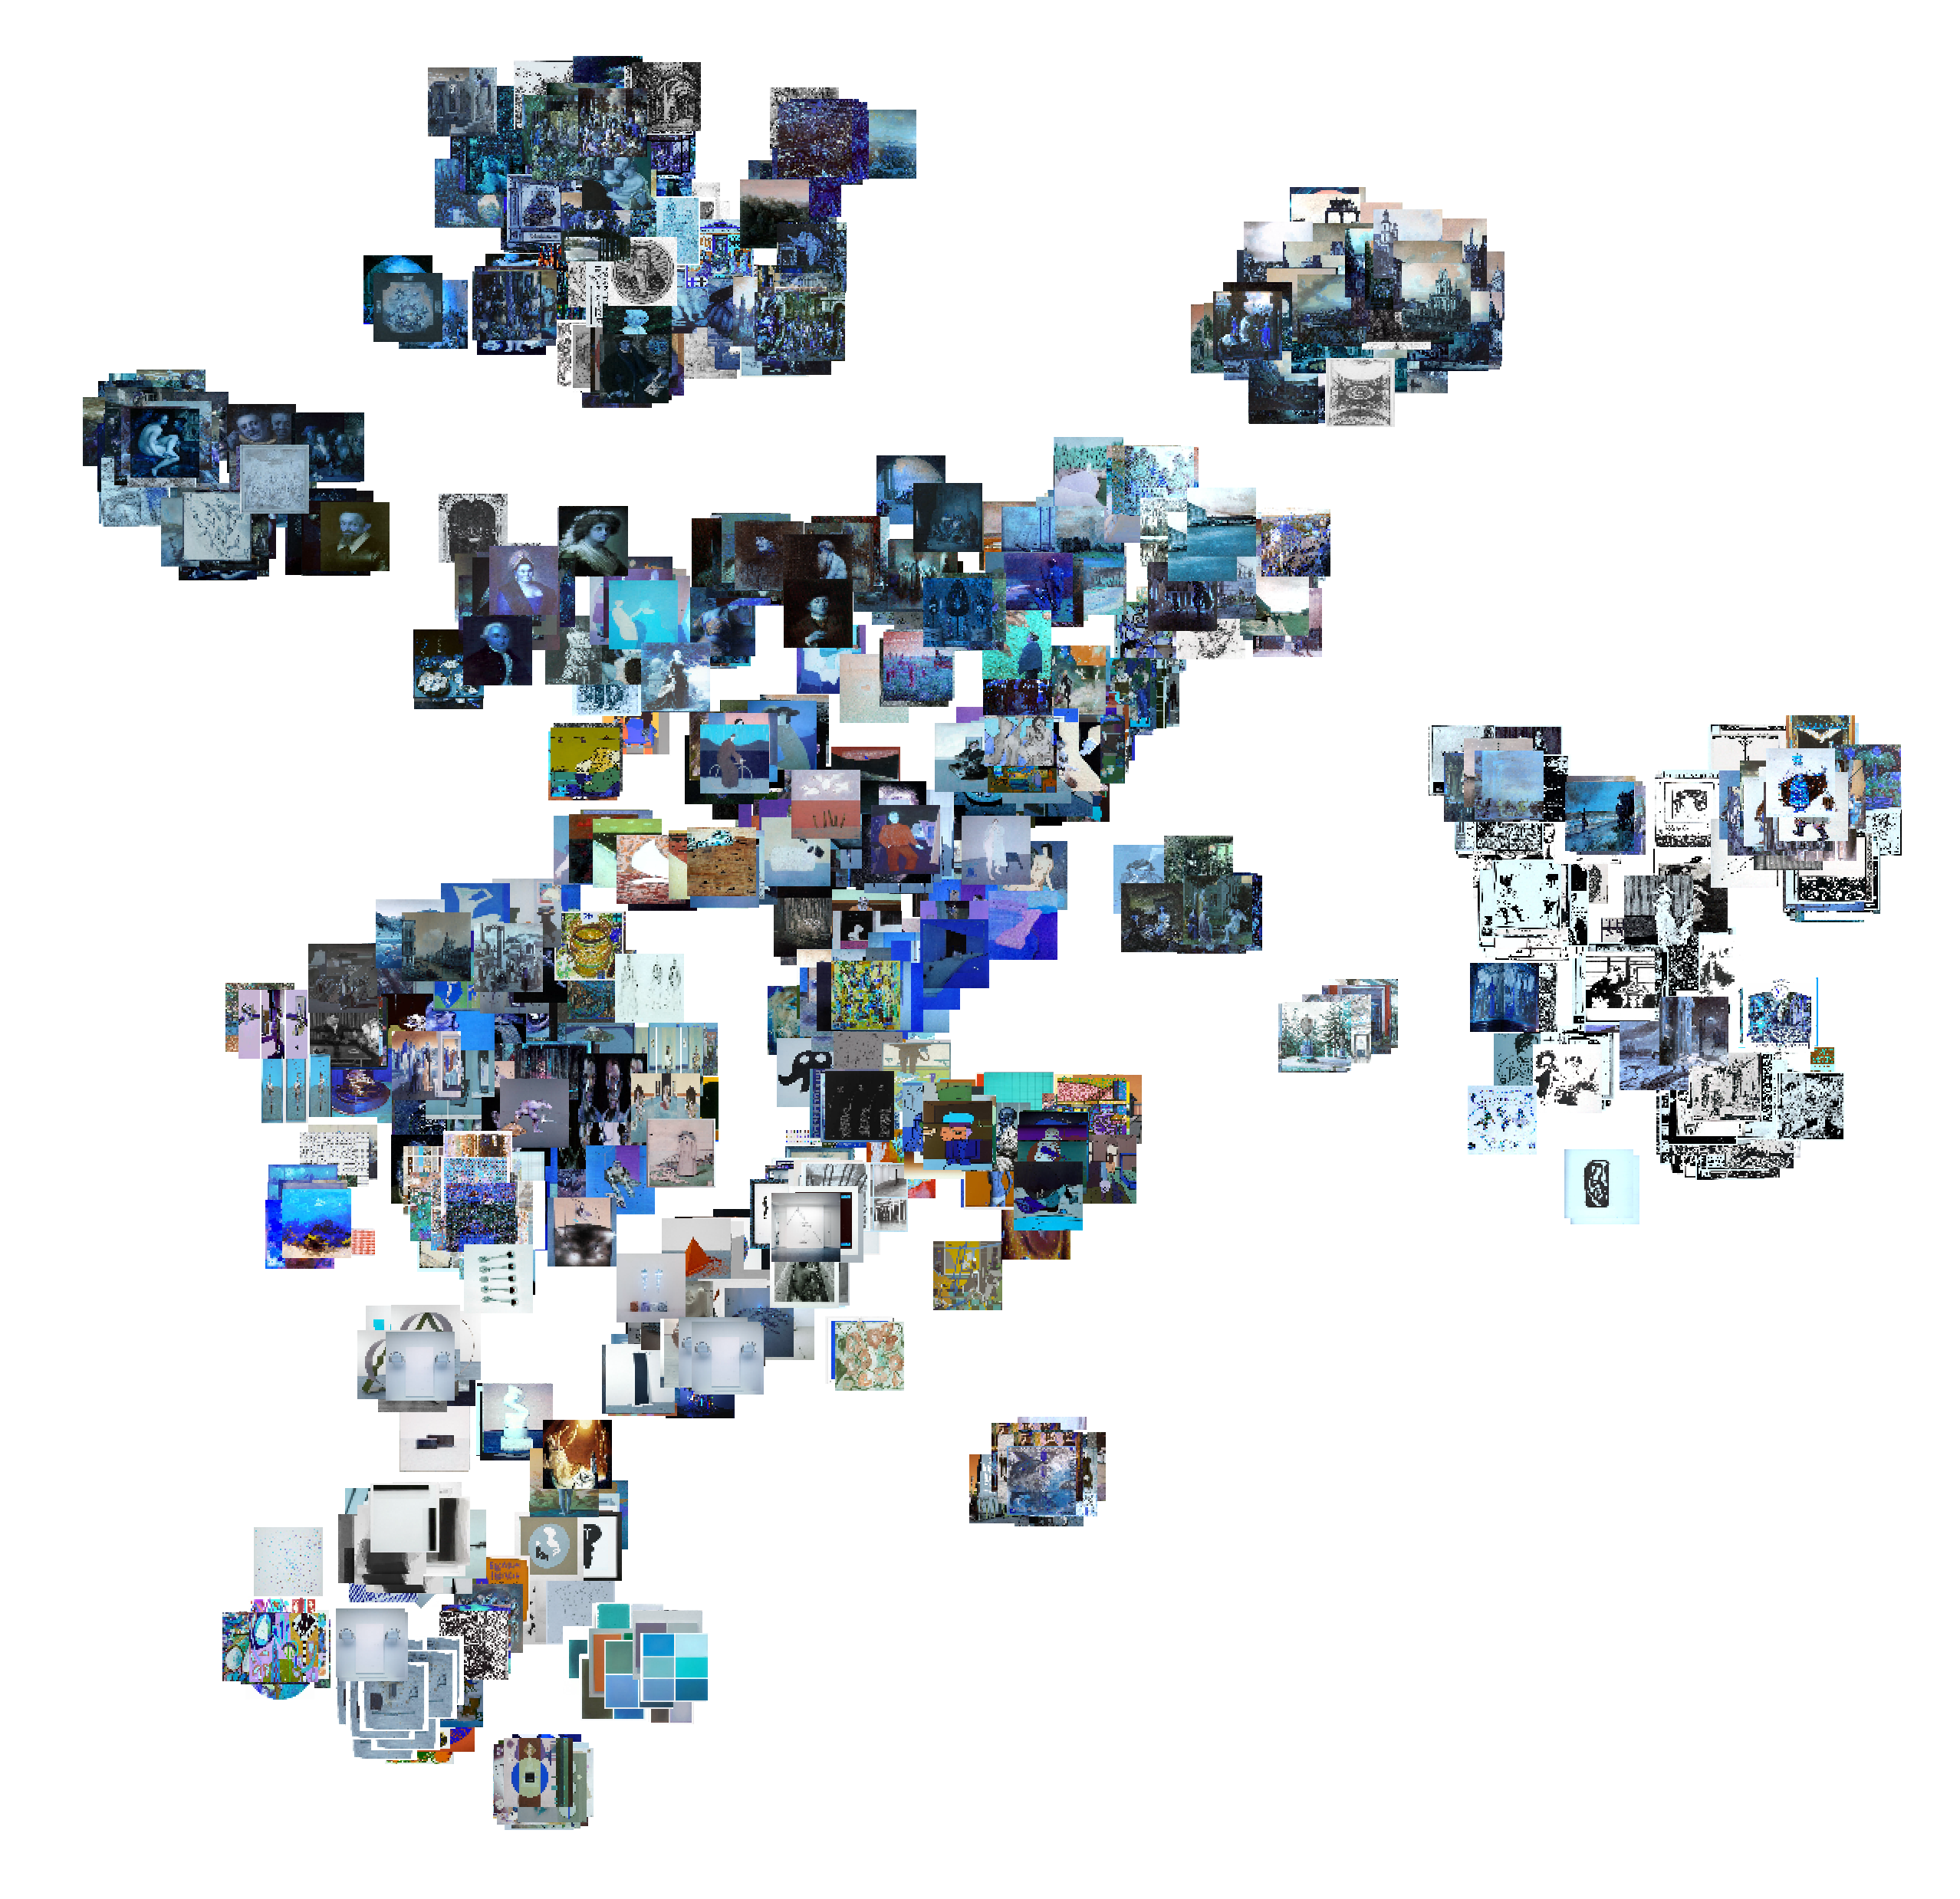

In [153]:
visualize_scatter_with_images(tsne_result_scaled, 
                                  pics, 
                                  figsize=(45,45), 
                                  image_zoom=2)

In [154]:
import pandas as pd

dct = {'x': tsne_result_scaled[:,0], 'y': tsne_result_scaled[:, 1],
       'label': labels, 'href': hrefs, 'title': titles, 'author': authors}
df = pd.DataFrame.from_dict(dct).to_csv('TSNE_ART_DICT.csv')

In [155]:
df = pd.DataFrame.from_dict(dct)
df.sample(200).to_csv('TSNE_ART_DICT_CUT.csv')

In [143]:
df.describe()

x             y
count  1.554000e+03  1.554000e+03
mean   8.256049e-09  1.699154e-07
std    1.000322e+00  1.000322e+00
min   -2.157189e+00 -2.137758e+00
25%   -6.364904e-01 -6.956891e-01
50%    5.641610e-02  1.442891e-01
75%    6.782324e-01  8.031914e-01
max    2.016674e+00  1.782743e+00